In [ ]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.tree import plot_tree
from sklearn.impute import SimpleImputer
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import SelectKBest, f_classif

In [ ]:
# Load a CSV file
df = pd.read_csv('/content/Crowd data for anomaly detection.csv')

In [ ]:
df.describe()

,X,Y,Speed,Heading,AgentCount,Density,Acc,LevelOfCrowdness,label,Severity_level
count,24123.000000,24123.000000,24123.000000,24123.000000,24123.000000,24123.000000,24019.000000,24123.000000,24123.000000,24123.000000
mean,0.319789,19.989362,0.742941,90.314782,251.092277,2.510923,0.004203,2.337064,0.288977,0.509265
std,0.067545,1.205473,0.279331,4.803848,167.615884,1.676159,0.032528,1.456331,0.453297,0.857201
min,-1.205900,11.162700,0.124400,84.324100,1.000000,0.010000,-1.031300,1.000000,0.000000,0.000000
25%,0.264500,19.575700,0.496700,88.475950,134.000000,1.340000,-0.001400,1.000000,0.000000,0.000000
50%,0.325400,20.288600,0.784300,89.170200,187.000000,1.870000,0.006300,2.000000,0.000000,0.000000
75%,0.356800,20.692900,1.005900,89.798100,336.000000,3.360000,0.013900,3.000000,1.000000,1.000000
max,1.966700,23.771700,1.567800,138.162100,990.000000,9.900000,0.455500,5.000000,1.000000,3.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24123 entries, 0 to 24122
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   timestamp         24123 non-null  object 
 1   X                 24123 non-null  float64
 2   Y                 24123 non-null  float64
 3   Speed             24123 non-null  float64
 4   Heading           24123 non-null  float64
 5   AgentCount        24123 non-null  int64  
 6   Density           24123 non-null  float64
 7   Acc               24019 non-null  float64
 8   LevelOfCrowdness  24123 non-null  int64  
 9   label             24123 non-null  int64  
 10  label2            24123 non-null  object 
 11  Severity_level    24123 non-null  int64  
dtypes: float64(6), int64(4), object(2)
memory usage: 2.2+ MB


In [ ]:
# Identify rows where 'Acc' column is null
rows_with_null_acc = df[df['Acc'].isnull()]

# Apply your desired method to counter null values for those rows
# For example, filling null values with the mean of 'Acc'
mean_acc = df['Acc'].mean()
df.loc[rows_with_null_acc.index, 'Acc'] = mean_acc  # Update only the 'Acc' column for the selected rows

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24123 entries, 0 to 24122
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   timestamp         24123 non-null  object 
 1   X                 24123 non-null  float64
 2   Y                 24123 non-null  float64
 3   Speed             24123 non-null  float64
 4   Heading           24123 non-null  float64
 5   AgentCount        24123 non-null  int64  
 6   Density           24123 non-null  float64
 7   Acc               24123 non-null  float64
 8   LevelOfCrowdness  24123 non-null  int64  
 9   label             24123 non-null  int64  
 10  label2            24123 non-null  object 
 11  Severity_level    24123 non-null  int64  
dtypes: float64(6), int64(4), object(2)
memory usage: 2.2+ MB


In [ ]:
# Initialize a dictionary to hold LevelOfCrowdness as keys and sets of Density as values
crowdness_dict = defaultdict(set)

# Iterate over the DataFrame and populate the dictionary
for _, row in df.iterrows():
    level_of_crowdness = row['LevelOfCrowdness']
    density = row['Density']
    crowdness_dict[level_of_crowdness].add(density)

# Convert sets to sorted lists
sorted_crowdness_dict = {k: sorted(v) for k, v in crowdness_dict.items()}

for i in sorted_crowdness_dict:
    print(str(i) + " " + str(sorted_crowdness_dict[i]) )

1 [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5, 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.6, 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69,

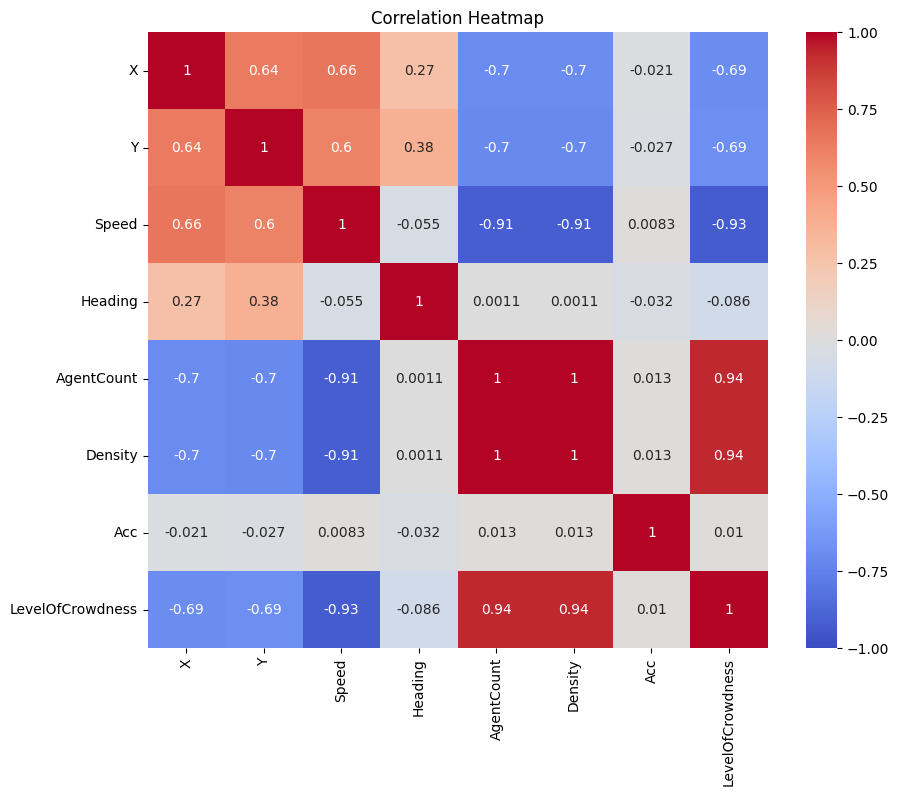

In [ ]:
# Select specific columns to include in the correlation matrix
columns_of_interest = ['X', 'Y', 'Speed', 'Heading', 'AgentCount', 'Density', 'Acc', 'LevelOfCrowdness']
selected_df = df[columns_of_interest]

# Calculate the correlation matrix for the selected columns
correlation_matrix = selected_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Rotate the labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Drop multiple columns
columns_to_drop = ['Density', 'LevelOfCrowdness', 'label2', 'Severity_level']
df.drop(columns_to_drop, axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24123 entries, 0 to 24122
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  24123 non-null  object 
 1   X          24123 non-null  float64
 2   Y          24123 non-null  float64
 3   Speed      24123 non-null  float64
 4   Heading    24123 non-null  float64
 5   Density    24123 non-null  float64
 6   Acc        24123 non-null  float64
 7   label      24123 non-null  int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 1.5+ MB


##Normal Testing with the Decision Tree Model

Column names in the dataset: Index(['timestamp', 'X', 'Y', 'Speed', 'Heading', 'AgentCount', 'Density',
       'Acc', 'LevelOfCrowdness', 'label', 'label2', 'Severity_level'],
      dtype='object')
Confusion Matrix:
[[5065    0]
 [   2 2170]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5065
           1       1.00      1.00      1.00      2172

    accuracy                           1.00      7237
   macro avg       1.00      1.00      1.00      7237
weighted avg       1.00      1.00      1.00      7237



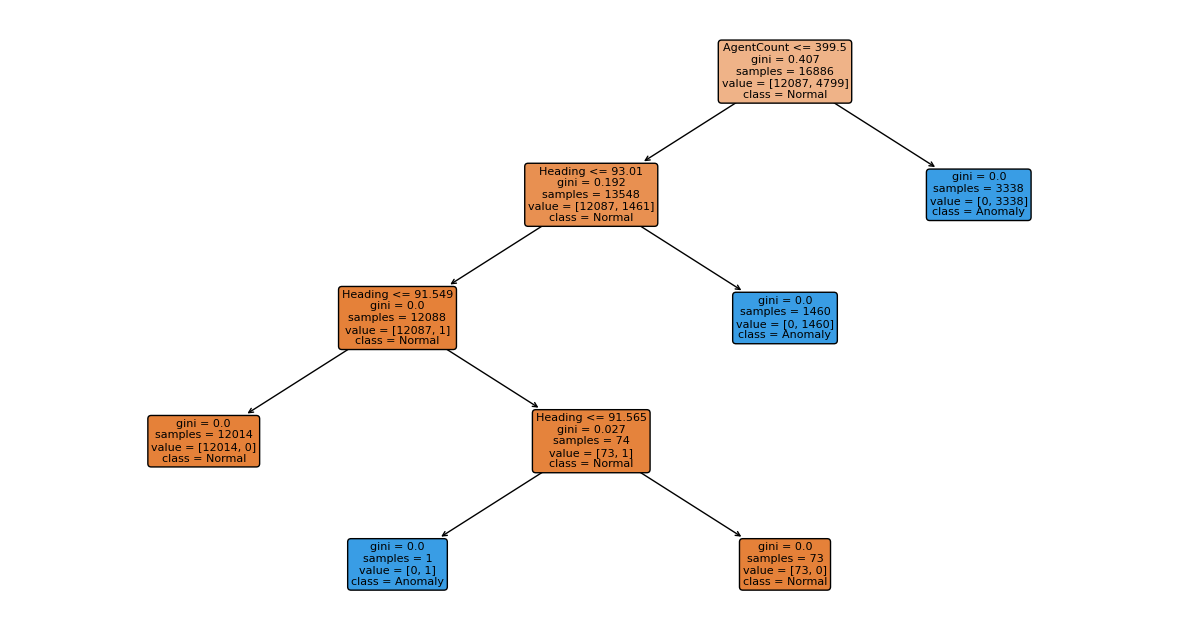

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'Crowd data for anomaly detection.csv'
data = pd.read_csv(file_path)

# Check the column names in the dataset
print("Column names in the dataset:", data.columns)

# Fill missing values in the 'Acc' column with the mean
if 'Acc' in data.columns:
    data['Acc'] = data['Acc'].fillna(data['Acc'].mean())

# Columns to drop
columns_to_drop = ['timestamp', 'X', 'Y', 'Density', 'LevelOfCrowdness', 'label2', 'Severity_level']

# Check if 'label' column exists
if 'label' not in data.columns:
    print("Error: 'label' column is not present in the dataset.")
else:
    # Define features and target variable
    features = data.drop(columns=columns_to_drop + ['label'])  # Drop specified columns including 'label'
    target = data['label']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

    # Train the decision tree model
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # Evaluate the model
    y_pred = clf.predict(X_test)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Visualize the decision tree
    plt.figure(figsize=(15, 8))  # Adjust the figure size
    plot_tree(clf, filled=True, feature_names=features.columns, class_names=['Normal', 'Anomaly'], rounded=True, fontsize=8)  # Adjust the fontsize
    plt.show()

##IQR

X:
Lower bound: 0.12605000000000002, Upper bound: 0.49524999999999997
Number of outliers: 280
---
Y:
Lower bound: 17.899900000000002, Upper bound: 22.368700000000004
Number of outliers: 3004
---
Speed:
Lower bound: -0.26710000000000017, Upper bound: 1.7697000000000003
Number of outliers: 0
---
Heading:
Lower bound: 86.49272500000002, Upper bound: 91.781325
Number of outliers: 3461
---
Density:
Lower bound: -1.6899999999999993, Upper bound: 6.389999999999999
Number of outliers: 286
---
Acc:
Lower bound: -0.024349999999999997, Upper bound: 0.036849999999999994
Number of outliers: 857
---


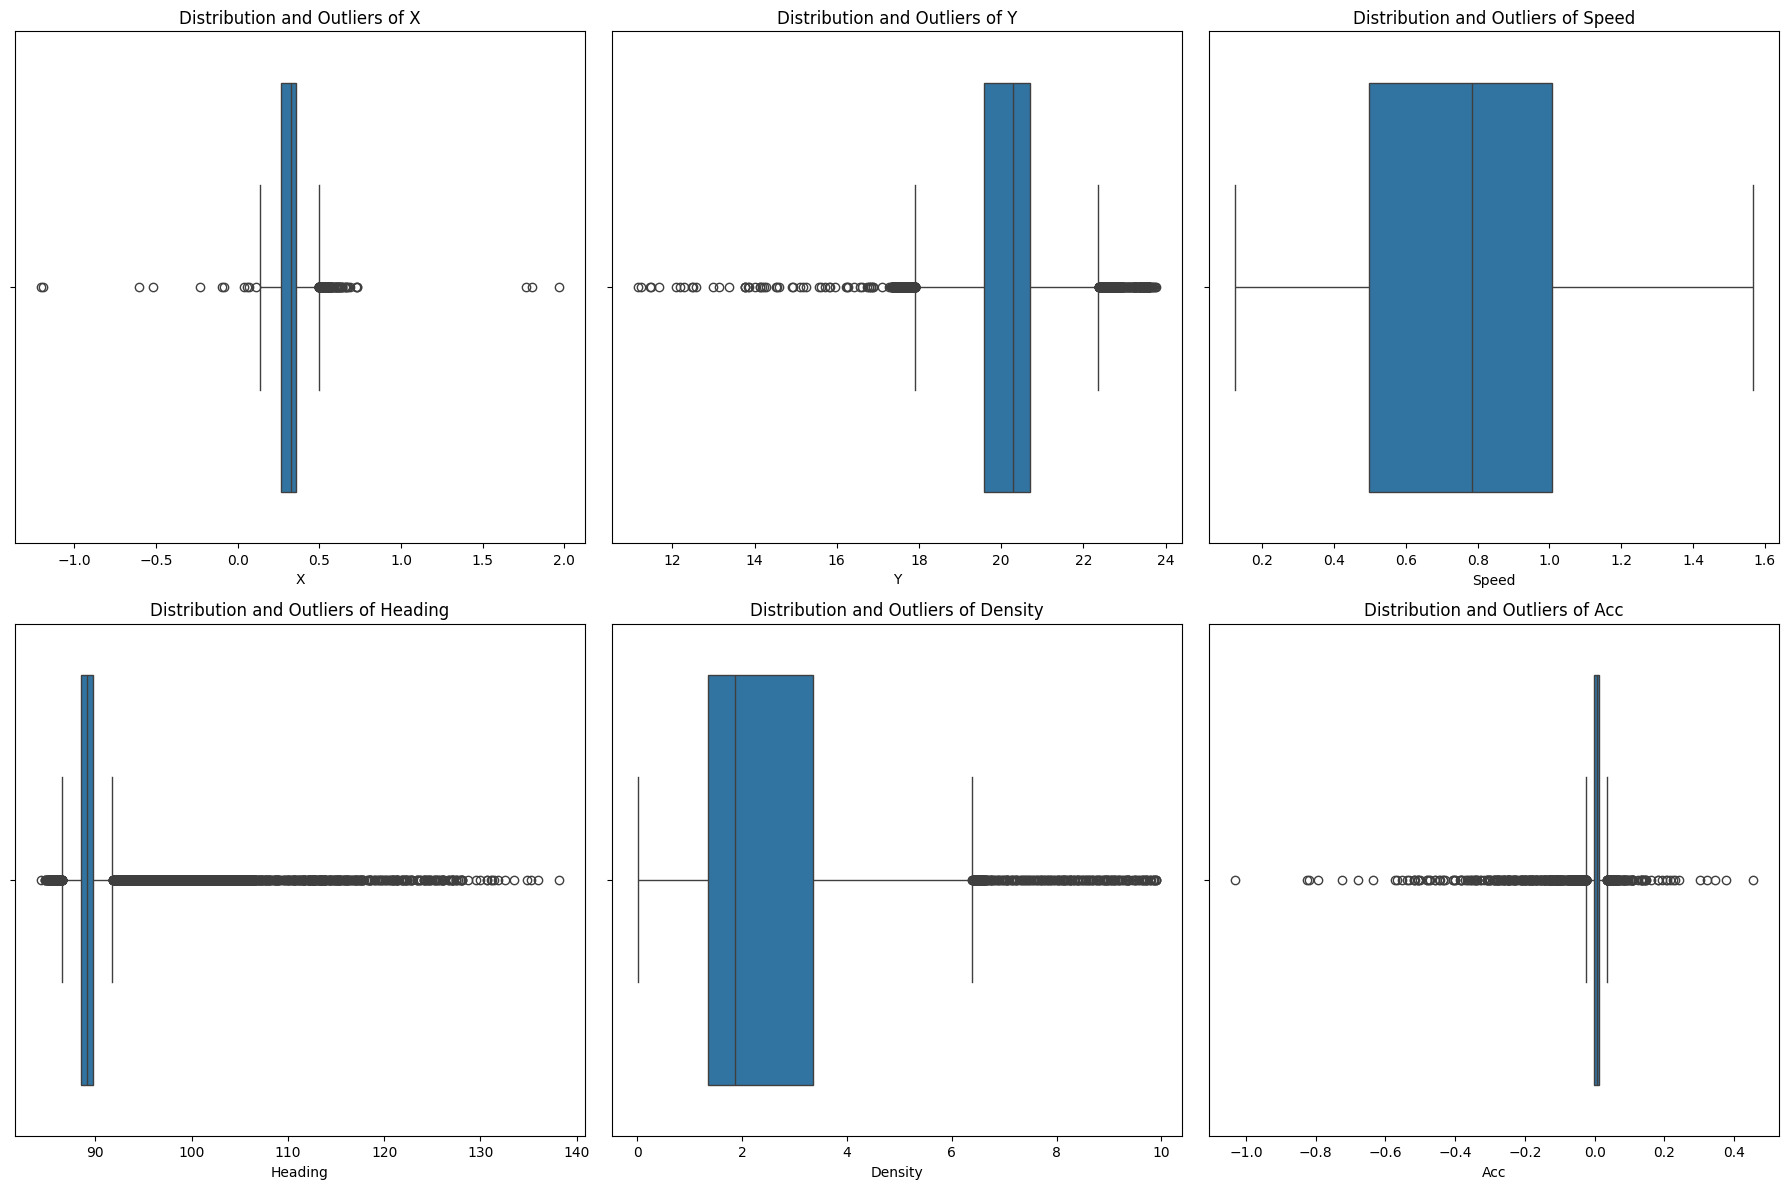

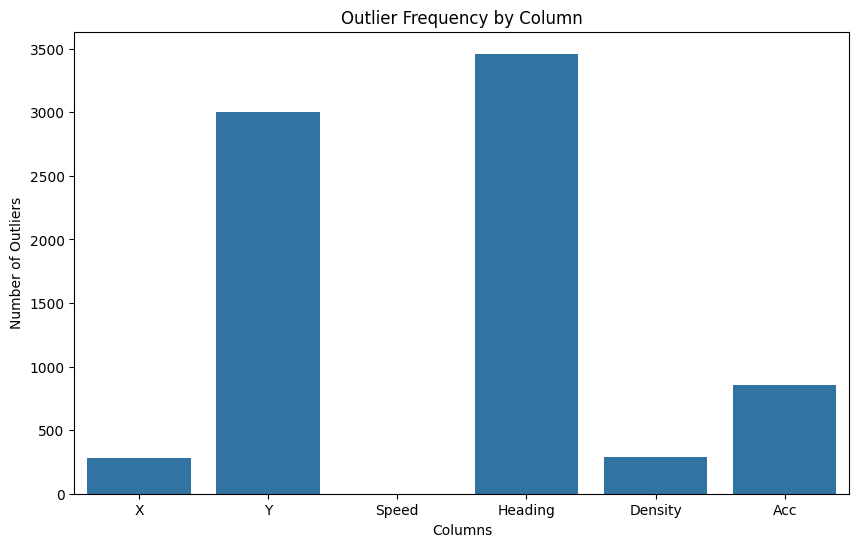

In [ ]:
# Define a function to calculate IQR and identify outliers
def calculate_iqr_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Apply the function to each numeric column
outliers_dict = defaultdict(list)
outlier_counts = {}

for col in ['X', 'Y', 'Speed', 'Heading', 'Density', 'Acc']:
    outliers, lower_bound, upper_bound = calculate_iqr_outliers(df, col)
    outliers_dict[col] = outliers
    outlier_counts[col] = len(outliers)
    print(f'{col}:')
    print(f'Lower bound: {lower_bound}, Upper bound: {upper_bound}')
    print(f'Number of outliers: {len(outliers)}')
    print('---')

# Plotting the distribution and outliers in subplots
def plot_distribution_with_outliers(data, columns):
    num_columns = len(columns)
    num_rows = (num_columns + 2) // 3  # Create rows as per requirement, 3 columns per row

    fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6 * num_rows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.boxplot(x=data[col], ax=axes[i])
        axes[i].set_title(f'Distribution and Outliers of {col}')

    for j in range(i + 1, len(axes)):  # Hide any unused subplots
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Columns to be plotted
columns = ['X', 'Y', 'Speed', 'Heading', 'Density', 'Acc']
plot_distribution_with_outliers(df, columns)

# Plotting the outlier frequency chart
def plot_outlier_frequency(outlier_counts):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(outlier_counts.keys()), y=list(outlier_counts.values()))
    plt.title('Outlier Frequency by Column')
    plt.xlabel('Columns')
    plt.ylabel('Number of Outliers')
    plt.show()

plot_outlier_frequency(outlier_counts)

# Optional: save the outliers to a CSV file
outliers_df = pd.concat(outliers_dict.values())
outliers_df.to_csv('/content/drive/MyDrive/IQR_Outliers.csv', index=False)

##Z-Score

X:
Mean: 0.31978861252746343, Standard Deviation: 0.06754468906132123
Number of outliers: 128
---
Y:
Mean: 19.9893618455416, Standard Deviation: 1.2054730806314715
Number of outliers: 50
---
Speed:
Mean: 0.742940533930274, Standard Deviation: 0.279330799792778
Number of outliers: 0
---
Heading:
Mean: 90.31478207519794, Standard Deviation: 4.803848425150347
Number of outliers: 510
---
Density:
Mean: 2.5109227707996515, Standard Deviation: 1.6761588432342391
Number of outliers: 140
---
Acc:
Mean: 0.004203368166867896, Standard Deviation: 0.03245795573563198
Number of outliers: 254
---


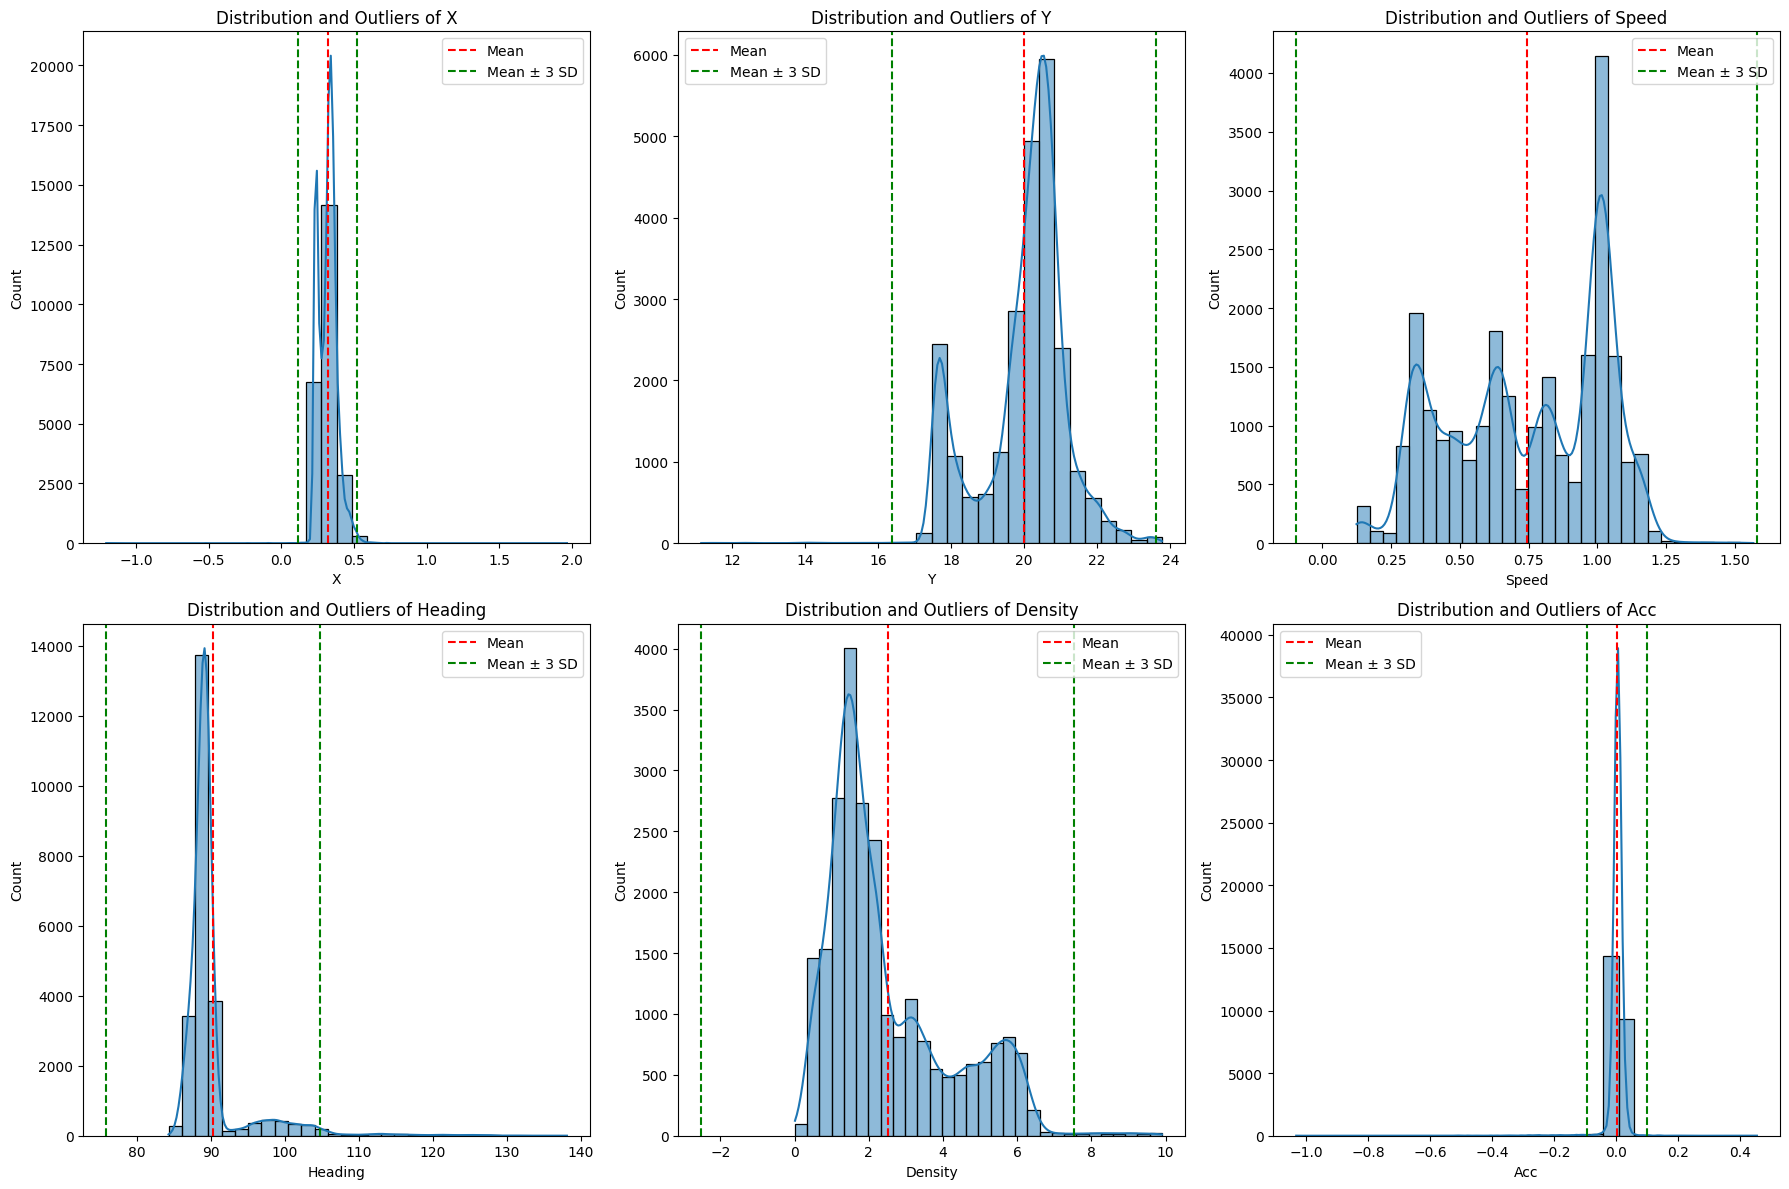

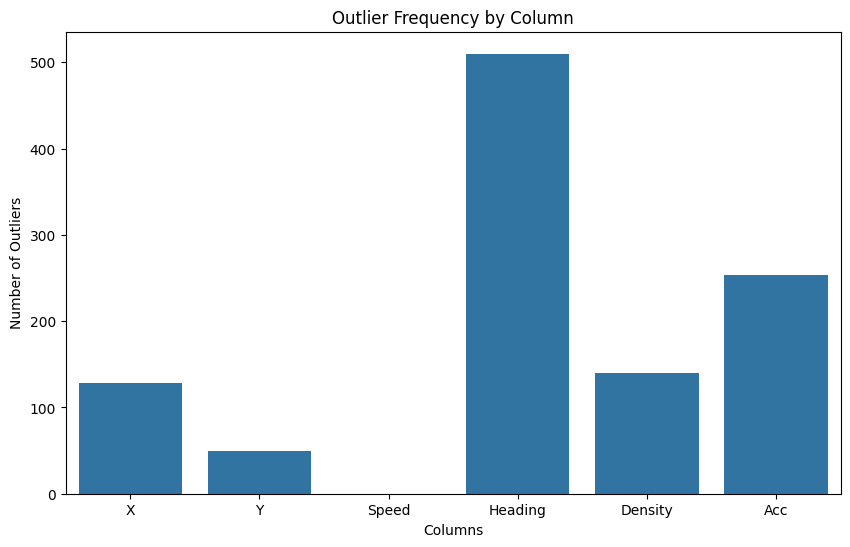

In [ ]:
# Define a function to calculate Z-score and identify outliers
def calculate_zscore_outliers(data, column):
    mean = data[column].mean()
    std = data[column].std()
    z_scores = (data[column] - mean) / std
    outliers = data[(z_scores < -3) | (z_scores > 3)]
    return outliers, mean, std

# Apply the function to each numeric column
outliers_dict = defaultdict(list)
outlier_counts = {}

for col in ['X', 'Y', 'Speed', 'Heading', 'Density', 'Acc']:
    outliers, mean, std = calculate_zscore_outliers(df, col)
    outliers_dict[col] = outliers
    outlier_counts[col] = len(outliers)
    print(f'{col}:')
    print(f'Mean: {mean}, Standard Deviation: {std}')
    print(f'Number of outliers: {len(outliers)}')
    print('---')

# Plotting the distribution and outliers in subplots
def plot_distribution_with_outliers(data, columns):
    num_columns = len(columns)
    num_rows = (num_columns + 2) // 3  # Create rows as per requirement, 3 columns per row

    fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6 * num_rows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.histplot(data[col], bins=30, kde=True, ax=axes[i])
        axes[i].axvline(data[col].mean(), color='r', linestyle='--', label='Mean')
        axes[i].axvline(data[col].mean() + 3 * data[col].std(), color='g', linestyle='--', label='Mean ± 3 SD')
        axes[i].axvline(data[col].mean() - 3 * data[col].std(), color='g', linestyle='--')
        axes[i].set_title(f'Distribution and Outliers of {col}')
        axes[i].legend()

    for j in range(i + 1, len(axes)):  # Hide any unused subplots
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Columns to be plotted
columns = ['X', 'Y', 'Speed', 'Heading', 'Density', 'Acc']
plot_distribution_with_outliers(df, columns)

# Plotting the outlier frequency chart
def plot_outlier_frequency(outlier_counts):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(outlier_counts.keys()), y=list(outlier_counts.values()))
    plt.title('Outlier Frequency by Column')
    plt.xlabel('Columns')
    plt.ylabel('Number of Outliers')
    plt.show()

plot_outlier_frequency(outlier_counts)

# Optional: save the outliers to a CSV file
outliers_df = pd.concat(outliers_dict.values())
outliers_df.to_csv('/content/drive/MyDrive/ZScore_Outliers.csv', index=False)

##Decision Tree

<ipython-input-13-33ef06e35bf8>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'])


Overall Confusion Matrix:
[[17151     1]
 [    3  6968]]

Overall Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17152
           1       1.00      1.00      1.00      6971

    accuracy                           1.00     24123
   macro avg       1.00      1.00      1.00     24123
weighted avg       1.00      1.00      1.00     24123


Overall Accuracy: 1.00
Outliers (identified in at least 1 fold):
                timestamp       X        Y   Speed  Heading  Density     Acc  \
6289  2024-06-21 00:53:51  0.4309  22.6042  0.8044  92.7143     1.62 -0.0115   
6409  2024-06-21 00:55:51  0.3840  20.1422  1.0908  93.0015     0.95  0.0027   
16224 2024-06-21 00:52:03  0.4079  22.1155  0.7235  91.5619     1.95 -0.0335   
16959 2024-06-21 00:04:31  0.3891  21.1700  1.0174  91.5672     0.55 -0.0061   

       label  
6289       1  
6409       1  
16224      1  
16959      0  


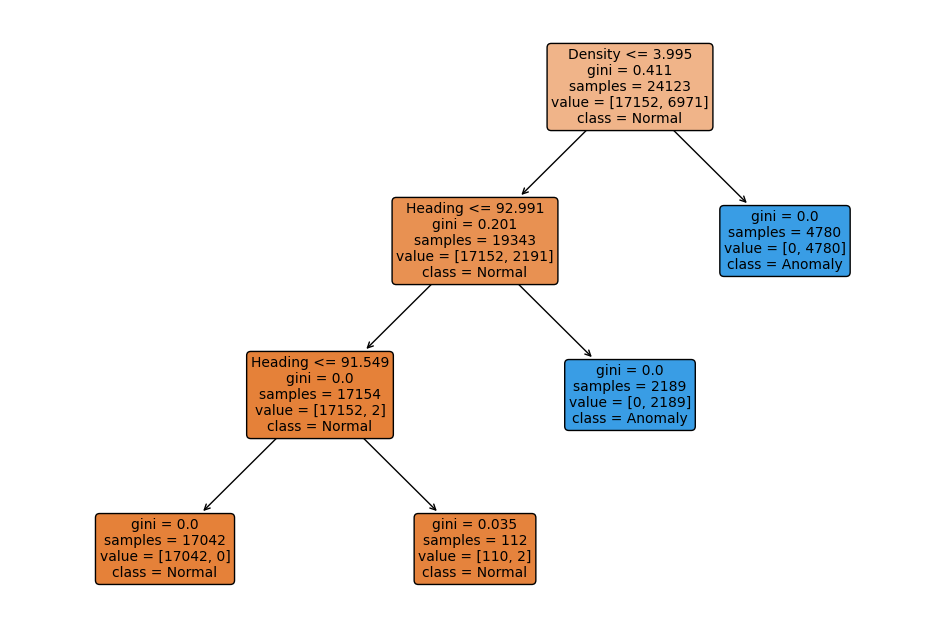

Non-numeric columns: Index([], dtype='object')
Model saved to /content/drive/MyDrive/decision_tree_model.joblib


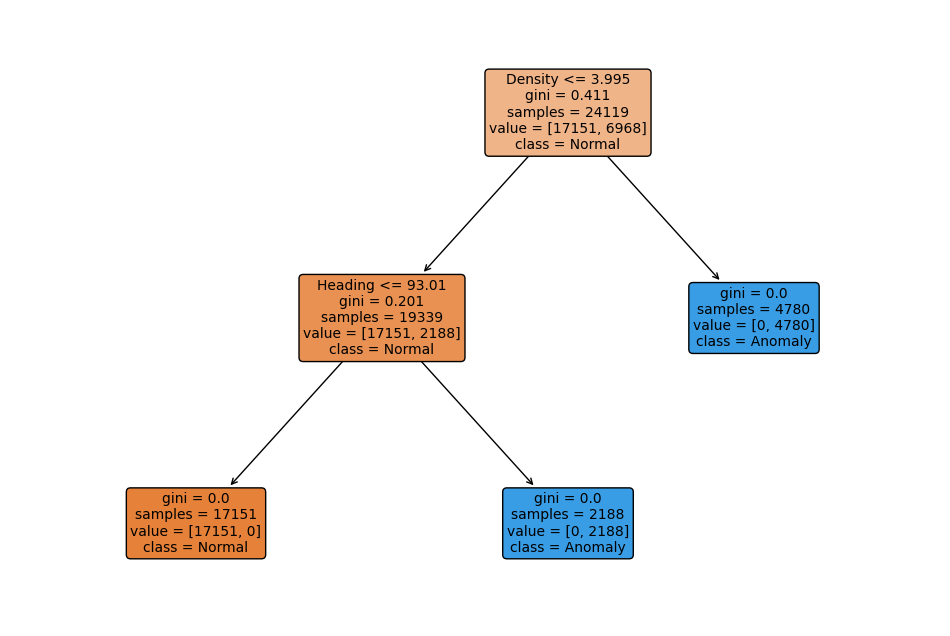


Final Model Accuracy on Cleaned Dataset: 1.00


In [ ]:
# Load the dataset
df = pd.read_csv('/content/Crowd data for anomaly detection.csv')

# Fill null values in 'Acc' with the mean
mean_acc = df['Acc'].mean()
df['Acc'].fillna(mean_acc, inplace=True)

# Drop unnecessary columns
columns_to_drop = ['AgentCount', 'LevelOfCrowdness', 'label2', 'Severity_level']
df.drop(columns_to_drop, axis=1, inplace=True)

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Define features and target variable
features = df.drop(['timestamp', 'label'], axis=1)
target = df['label']

# Initialize the k-fold cross-validation
kf = KFold(n_splits=len(df), shuffle=True, random_state=42)  # Setting n_splits to len(df) for leave-one-out CV
outliers = np.zeros(len(df))

# Accumulate predictions and ground truth
all_y_true = []
all_y_pred = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(features):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    # Train the decision tree model
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # Evaluate the model
    y_pred = clf.predict(X_test)

    # Accumulate results for global confusion matrix
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    # Identify outliers (misclassified instances)
    outliers[test_index] += (y_test != y_pred).astype(int)

# Calculate and print the overall confusion matrix and classification report
print("Overall Confusion Matrix:")
print(confusion_matrix(all_y_true, all_y_pred))
print("\nOverall Classification Report:")
print(classification_report(all_y_true, all_y_pred))

# Calculate and print the overall accuracy
overall_accuracy = accuracy_score(all_y_true, all_y_pred)
print(f"\nOverall Accuracy: {overall_accuracy:.2f}")

# Instances identified as outliers in most folds (threshold can be adjusted)
outlier_threshold = 1  # Since it's leave-one-out, any misclassification is an outlier
outlier_indices = np.where(outliers >= outlier_threshold)[0]
outlier_data = df.iloc[outlier_indices]

print(f"Outliers (identified in at least {outlier_threshold} fold):")
print(outlier_data)

# Plot the decision tree before removing outliers
clf_initial = DecisionTreeClassifier(random_state=42, max_depth=3)
clf_initial.fit(features, target)

plt.figure(figsize=(12, 8))  # Adjust figsize
plot_tree(clf_initial,
          filled=True,
          feature_names=features.columns,
          class_names=['Normal', 'Anomaly'],
          rounded=True,
          fontsize=10)
plt.show()

# Optionally remove outliers from the dataset before training the final model
df_clean = df.drop(outlier_indices)
features_clean = df_clean.drop(['timestamp', 'label'], axis=1)
target_clean = df_clean['label']

# Check for non-numeric columns and drop them
non_numeric_cols = features_clean.select_dtypes(include=['object']).columns
print(f"Non-numeric columns: {non_numeric_cols}")
features_clean = features_clean.drop(non_numeric_cols, axis=1)

# Fit the decision tree with a maximum depth to avoid overly large plots
clf_final = DecisionTreeClassifier(random_state=42, max_depth=3)  # Setting max_depth to 3
clf_final.fit(features_clean, target_clean)

# Save the trained model to a file
model_filename = '/content/drive/MyDrive/decision_tree_model.joblib'
joblib.dump(clf_final, model_filename)
print(f"Model saved to {model_filename}")

# Function to annotate the decision tree plot with node sizes
def annotate_tree(tree, ax=None):
    if ax is None:
        ax = plt.gca()

    counts = tree.tree_.n_node_samples  # Get the number of samples in each node
    for i, count in enumerate(counts):
        bbox_props = dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
        ax.text(i, tree.tree_.threshold[i], f'{count}', va='center', ha='center', bbox=bbox_props)

# Visualize the decision tree trained on the cleaned dataset
plt.figure(figsize=(12, 8))  # Adjust figsize
plot_tree(clf_final,
          filled=True,
          feature_names=features_clean.columns,
          class_names=['Normal', 'Anomaly'],
          rounded=True,
          fontsize=10)
plt.show()

# Calculate and print the accuracy on the cleaned dataset
final_accuracy = clf_final.score(features_clean, target_clean)
print(f"\nFinal Model Accuracy on Cleaned Dataset: {final_accuracy:.2f}")

##Isolation Forest

<ipython-input-11-d1a4c43742ce>:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')


Best parameters found: {'contamination': 'auto', 'max_features': 0.8, 'max_samples': 0.9, 'n_estimators': 50}
Average Metrics after K-Fold Cross-Validation:
Precision: 0.6497
Recall: 0.0692
F1 Score: 0.1251
Accuracy: 0.7204
Model saved to /content/drive/MyDrive/isolation_forest_model.joblib


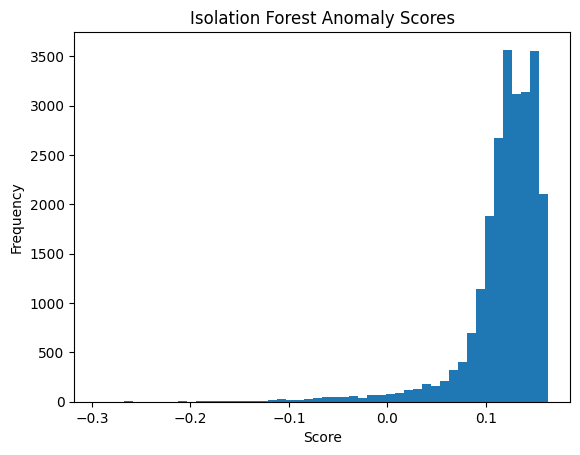

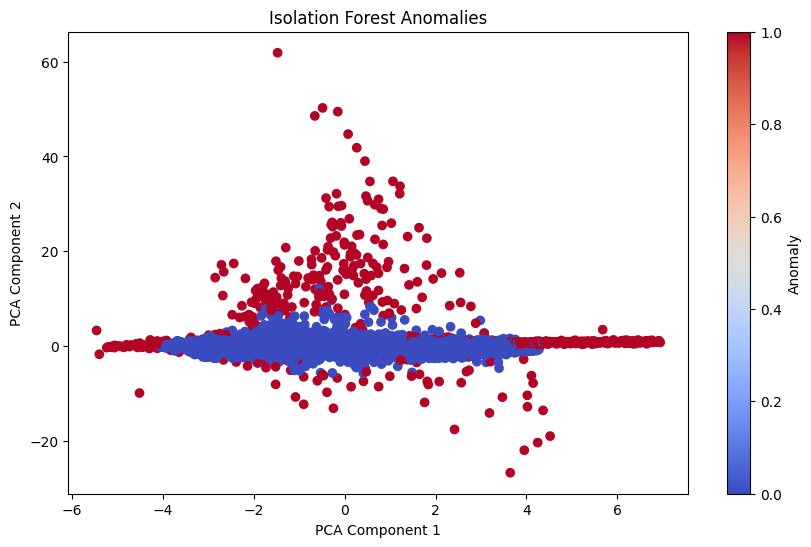


Anomalies detected in the entire dataset:
                timestamp   Speed  Heading  Density     Acc  label  \
845   2024-06-22 00:19:41  0.8453  88.9980     1.74 -0.1779      0   
993   2024-06-22 00:22:09  0.6393  89.1615     2.07 -0.2114      0   
1113  2024-06-22 00:24:09  0.6205  89.7222     2.09 -0.1442      0   
1191  2024-06-22 00:25:27  0.6606  88.6009     1.95 -0.1529      0   
1274  2024-06-22 00:26:50  0.5716  87.9579     2.24 -0.2684      0   
...                   ...     ...      ...      ...     ...    ...   
23474 2024-06-22 00:48:26  1.1248  89.1497     1.43  0.0680      0   
23511 2024-06-22 00:49:03  1.1506  89.2948     1.42 -0.0742      0   
23533 2024-06-22 00:49:25  1.1693  89.0261     1.36 -0.1271      0   
23557 2024-06-22 00:49:49  1.1337  88.4769     1.34 -0.0653      0   
23566 2024-06-22 00:49:58  1.1565  88.8676     1.33  0.0704      0   

       anomaly_score  anomaly  
845        -0.044721        1  
993        -0.004945        1  
1113       -0.010811

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

# Load the dataset
df = pd.read_csv('/content/Crowd data for anomaly detection.csv')

# Fill null values in 'Acc' with the mean
mean_acc = df['Acc'].mean()
df['Acc'].fillna(mean_acc, inplace=True)

# Drop unnecessary columns
columns_to_drop = ['X','Y','AgentCount', 'LevelOfCrowdness', 'label2', 'Severity_level']
df.drop(columns_to_drop, axis=1, inplace=True)

# Convert timestamp to datetime (allow for mixed formats)
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Define features and target variable
features = df.drop(['timestamp', 'label'], axis=1)
target = df['label']

# Define the feature indices you want to use (example indices)
selected_feature_indices = [0, 1, 2, 3]  # Update with your actual indices
selected_feature_names = features.columns[selected_feature_indices]

# Feature Engineering: Adding polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
features_poly = poly.fit_transform(features[selected_feature_names])

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_poly)

# Hyperparameter Tuning for Isolation Forest using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_samples': ['auto', 0.8, 0.9],
    'contamination': ['auto', 0.1, 0.2],
    'max_features': [1.0, 0.8, 0.9]
}
grid_search = GridSearchCV(IsolationForest(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(features_scaled, target)

print(f"Best parameters found: {grid_search.best_params_}")

# Initialize KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics for each fold
conf_matrices = []
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []

# Perform K-Fold cross-validation
for train_index, test_index in kf.split(features_scaled):
    X_train, X_test = features_scaled[train_index], features_scaled[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    # Train the Isolation Forest model with best parameters
    clf = IsolationForest(**grid_search.best_params_, random_state=42)
    clf.fit(X_train)

    # Evaluate the model on test set
    y_pred = clf.predict(X_test)
    y_pred = np.where(y_pred == 1, 0, 1)  # Map predictions to match binary target (0 for normal, 1 for anomaly)

    # Calculate and store metrics
    conf_matrix = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    conf_matrices.append(conf_matrix)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)

# Calculate average metrics
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)
avg_accuracy = np.mean(accuracy_scores)

print("Average Metrics after K-Fold Cross-Validation:")
print(f"Precision: {avg_precision:.4f}")
print(f"Recall: {avg_recall:.4f}")
print(f"F1 Score: {avg_f1:.4f}")
print(f"Accuracy: {avg_accuracy:.4f}")

# Train the final model on the entire dataset with best parameters
clf_final = IsolationForest(**grid_search.best_params_, random_state=42)
clf_final.fit(features_scaled)

# Save the trained model to a file
model_filename = '/content/drive/MyDrive/isolation_forest_model.joblib'
joblib.dump(clf_final, model_filename)
print(f"Model saved to {model_filename}")

# Add anomaly scores and predictions to the DataFrame
df['anomaly_score'] = clf_final.decision_function(features_scaled)
df['anomaly'] = clf_final.predict(features_scaled)
df['anomaly'] = df['anomaly'].map({1: 0, -1: 1})

# Visualize the decision function (anomaly scores) for the final model
scores = clf_final.decision_function(features_scaled)
plt.hist(scores, bins=50)
plt.title('Isolation Forest Anomaly Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

# Reduce the feature dimensions to 2 for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=df['anomaly'], cmap='coolwarm', label='Data points')
plt.title('Isolation Forest Anomalies')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Anomaly')
plt.show()

# Display anomalies identified by the final model
print("\nAnomalies detected in the entire dataset:")
print(df[df['anomaly'] == 1])

##Local Outlier Factor

<ipython-input-10-821ce1ad1d5d>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'])


Confusion Matrix:
[[17005   147]
 [ 6860   111]]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.99      0.83     17152
           1       0.43      0.02      0.03      6971

    accuracy                           0.71     24123
   macro avg       0.57      0.50      0.43     24123
weighted avg       0.63      0.71      0.60     24123

Precision: 0.4302
Recall: 0.0159
F1 Score: 0.0307
Accuracy: 0.7095


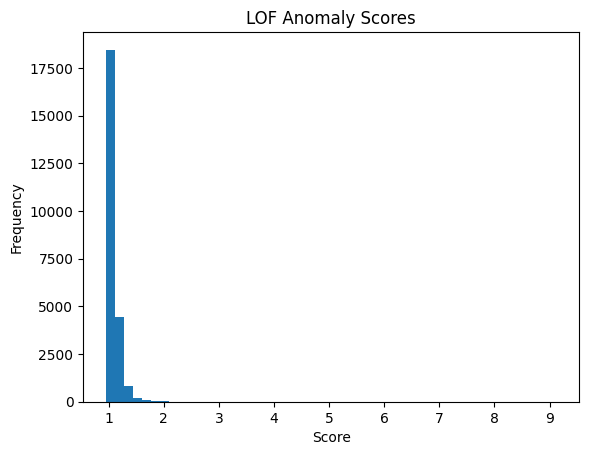

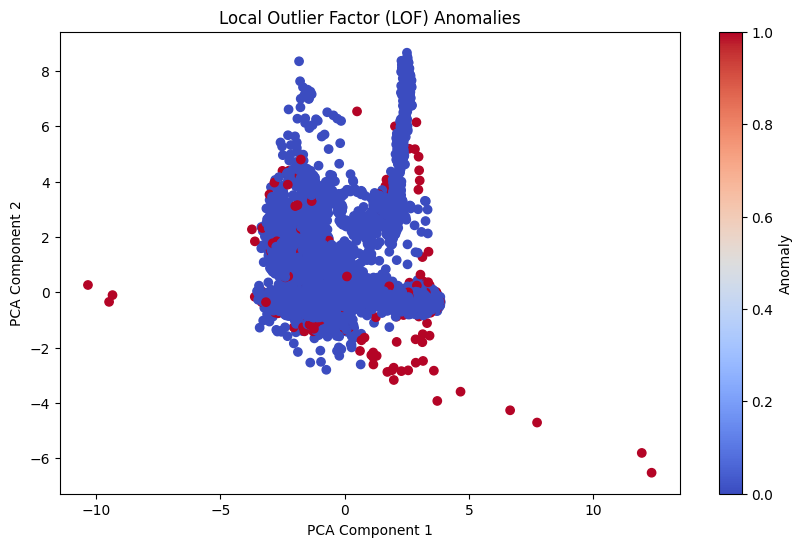


Anomalies detected in the dataset:
                timestamp       X        Y   Speed  Heading  Density     Acc  \
179   2024-06-21 00:08:35  0.3961  20.2156  1.1752  88.6538     0.78  0.0286   
606   2024-06-21 00:15:42  0.3904  19.0515  0.9372  89.5516     1.27  0.0245   
748   2024-06-21 00:18:04  0.3045  21.0239  0.8950  88.2255     1.63  0.0379   
909   2024-06-21 00:20:45  0.3912  20.0143  0.7669  91.2143     1.60 -0.0053   
953   2024-06-21 00:21:29  0.3671  19.6233  0.6823  90.7984     2.03  0.0067   
...                   ...     ...      ...     ...      ...      ...     ...   
23179 2024-06-21 00:43:31  0.2541  18.8145  0.5328  88.8929     4.02 -0.0516   
23365 2024-06-21 00:46:37  0.3600  20.5029  0.9604  88.9543     1.97  0.0036   
23474 2024-06-21 00:48:26  0.3118  20.5856  1.1248  89.1497     1.43  0.0680   
23532 2024-06-21 00:49:24  0.3323  20.9728  1.1668  90.0026     1.38 -0.0217   
23566 2024-06-21 00:49:58  0.3387  20.5836  1.1565  88.8676     1.33  0.0704   

   

In [ ]:
# Load the dataset
df = pd.read_csv('/content/Crowd data for anomaly detection.csv')

# Fill null values in 'Acc' with the mean
mean_acc = df['Acc'].mean()
df['Acc'].fillna(mean_acc, inplace=True)

# Drop unnecessary columns
columns_to_drop = ['AgentCount', 'LevelOfCrowdness', 'label2', 'Severity_level']
df.drop(columns_to_drop, axis=1, inplace=True)

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Define features and target variable
features = df.drop(['timestamp', 'label'], axis=1)
target = df['label']

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
y_pred = lof.fit_predict(features_scaled)
y_pred = np.where(y_pred == 1, 0, 1)  # Map predictions to match binary target (0 for normal, 1 for anomaly)

# Evaluate the model
conf_matrix = confusion_matrix(target, y_pred)
precision = precision_score(target, y_pred)
recall = recall_score(target, y_pred)
f1 = f1_score(target, y_pred)
accuracy = accuracy_score(target, y_pred)

# Print evaluation metrics
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(target, y_pred))

# Display the metrics in a more readable format
metrics = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Accuracy': accuracy
}

for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Add LOF scores and predictions to the DataFrame
df['lof_score'] = -lof.negative_outlier_factor_
df['anomaly'] = y_pred

# Visualize the LOF scores
plt.hist(df['lof_score'], bins=50)
plt.title('LOF Anomaly Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

# Visualize anomalies using PCA
from sklearn.decomposition import PCA

# Reduce the feature dimensions to 2 for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=df['anomaly'], cmap='coolwarm', label='Data points')
plt.title('Local Outlier Factor (LOF) Anomalies')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Anomaly')
plt.show()

# Display anomalies identified by the LOF model
print("\nAnomalies detected in the dataset:")
print(df[df['anomaly'] == 1])

##Supervised Models

In [ ]:
!pip install xgboost
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Load the dataset
data = pd.read_csv('/content/Crowd data for anomaly detection.csv')

data = data.drop(['timestamp', 'label2', 'Severity_level'], axis=1)

# List of features to focus on
feature_list = ['Speed', 'Heading', 'AgentCount', 'Acc']

# Fill missing values with the mean of the column
data.fillna(data.mean(), inplace=True)

# Separating the features and the target variable
X = data[feature_list]
y = data['label']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# List of models to test
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Classifier': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Function to evaluate a model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Dictionary to store the results
results = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}

# Evaluating each model
for model_name, model in models.items():
    accuracy, precision, recall, f1 = evaluate_model(model, X_train, X_test, y_train, y_test)
    results['Model'].append(model_name)
    results['Accuracy'].append(round(accuracy, 3))
    results['Precision'].append(round(precision, 3))
    results['Recall'].append(round(recall, 3))
    results['F1-Score'].append(round(f1, 3))

# Creating a DataFrame from the results
results_df = pd.DataFrame(results)

# Saving the results to a CSV file
results_df.to_csv('Supervised_Models.csv', index=False)

print('Model evaluation completed and results saved to Supervised_Models.csv')

Model evaluation completed and results saved to Supervised_Models.csv


##Unsupervised Models

In [ ]:
!pip install xlsxwriter
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.mixture import GaussianMixture
from sklearn.cluster import OPTICS, MiniBatchKMeans
import itertools
import xlsxwriter

# Load the dataset
data = pd.read_csv('/content/Crowd data for anomaly detection.csv')

data = data.drop(['timestamp', 'label2', 'Severity_level'], axis=1)

# List of features to focus on
feature_list = ['AgentCount', 'Acc', 'Speed', 'Heading']

# Fill missing values with the mean of the column
data.fillna(data.mean(), inplace=True)

# Separating the target variable
y = data['label']

# List of models to test
anomaly_detection_models = {
    'Isolation Forest': IsolationForest(random_state=42),
    'Local Outlier Factor': LocalOutlierFactor(n_neighbors=20, contamination=0.1),
    'One-Class SVM': OneClassSVM(gamma='auto'),
    'Elliptic Envelope': EllipticEnvelope(contamination=0.1),
    'Gaussian Mixture': GaussianMixture(n_components=2, covariance_type='full', random_state=42),
    'OPTICS': OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.1),
    'MiniBatchKMeans': MiniBatchKMeans(n_clusters=2, random_state=42, batch_size=10)
}

# Function to evaluate an anomaly detection model
def evaluate_anomaly_model(model, X, y):
    if isinstance(model, (LocalOutlierFactor, OneClassSVM, EllipticEnvelope)):
        y_pred = model.fit_predict(X)
        # Convert outputs to binary: -1 -> anomaly (1), 1 -> normal (0)
        y_pred = np.where(y_pred == -1, 1, 0)
    elif isinstance(model, GaussianMixture):
        y_pred = model.fit_predict(X)
        # Convert Gaussian Mixture outputs to binary: 0 -> normal (0), 1 -> anomaly (1)
        y_pred = np.where(y_pred == 0, 0, 1)
    elif isinstance(model, OPTICS):
        model.fit(X)
        y_pred = model.labels_
        # Convert OPTICS outputs to binary: -1 -> anomaly (1), 0 or greater -> normal (0)
        y_pred = np.where(y_pred == -1, 1, 0)
    elif isinstance(model, MiniBatchKMeans):
        y_pred = model.fit_predict(X)
        # Assuming that smaller clusters represent anomalies, and larger clusters are normal
        cluster_sizes = np.bincount(y_pred)
        anomaly_clusters = np.where(cluster_sizes < np.mean(cluster_sizes))[0]
        y_pred = np.where(np.isin(y_pred, anomaly_clusters), 1, 0)
    else:
        model.fit(X)
        y_pred = model.predict(X)
        # Convert Isolation Forest outputs to binary: -1 -> anomaly (1), 1 -> normal (0)
        y_pred = np.where(y_pred == -1, 1, 0)

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Create a workbook and add a worksheet
workbook = xlsxwriter.Workbook('Unsupervised_Models_Evaluation.xlsx')
worksheet = workbook.add_worksheet()

# Write the header
header = ['Feature Combination', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
for col_num, header_title in enumerate(header):
    worksheet.write(0, col_num, header_title)

# Evaluate models for all combinations of features
row = 1
for r in range(1, len(feature_list) + 1):
    for combo in itertools.combinations(feature_list, r):
        X = data[list(combo)]

        # Splitting the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Standardizing the features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Evaluating anomaly detection models
        for model_name, model in anomaly_detection_models.items():
            accuracy, precision, recall, f1 = evaluate_anomaly_model(model, X_train, y_train)
            # Write results to the worksheet
            worksheet.write(row, 0, '_'.join(combo))
            worksheet.write(row, 1, model_name)
            worksheet.write(row, 2, round(accuracy, 3))
            worksheet.write(row, 3, round(precision, 3))
            worksheet.write(row, 4, round(recall, 3))
            worksheet.write(row, 5, round(f1, 3))
            row += 1

# Close the workbook
workbook.close()

print('Model evaluation completed and results saved to Unsupervised_Models_Evaluation.xlsx')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 1.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability

Model evaluation completed and results saved to Unsupervised_Models_Evaluation.xlsx


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
